### **DBSCAN**

> Indented block





Sales Prediction

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Import the libraries
import pandas as pd
import numpy 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

In [ ]:
#Reading the dataset
dataset = pd.read_csv("/content/drive/MyDrive/dataset/Mall_Customers.csv")

### **1.Data Exploration**
Schema of the dataset

In [ ]:
dataset.head() #Schema of the dataset

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40



Finding out the number of rows*number of column in the dataset

In [ ]:
dataset.shape #Dimension of the DataSet,number of rows*number of columns 

(200, 5)

### **2.Data Preprocessing**

In [ ]:
dataset.isna().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [ ]:
dataset.duplicated().any()

False

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


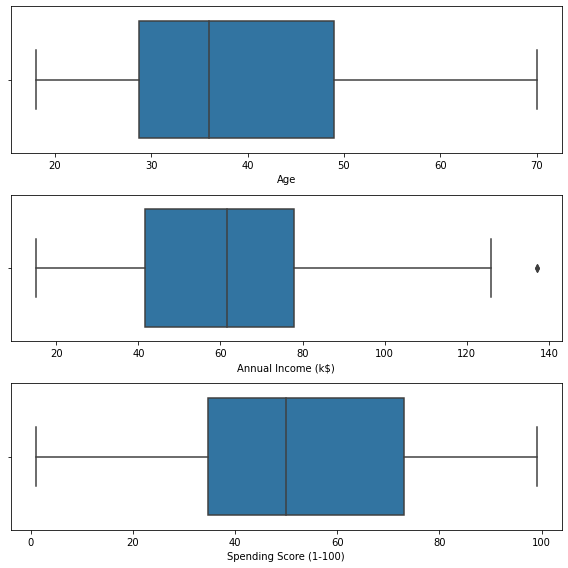

In [ ]:
fig, axs = plt.subplots(3, figsize = (8,8))
plt1 = sns.boxplot(dataset['Age'], ax = axs[0])
plt2 = sns.boxplot(dataset['Annual Income (k$)'], ax = axs[1])
plt3 = sns.boxplot(dataset['Spending Score (1-100)'], ax = axs[2])
plt.tight_layout()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


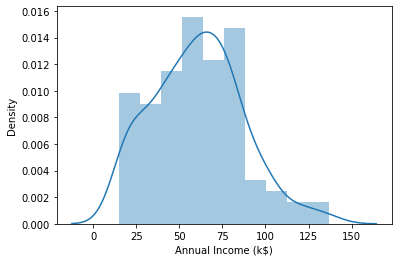

In [ ]:
sns.distplot(dataset['Annual Income (k$)']);

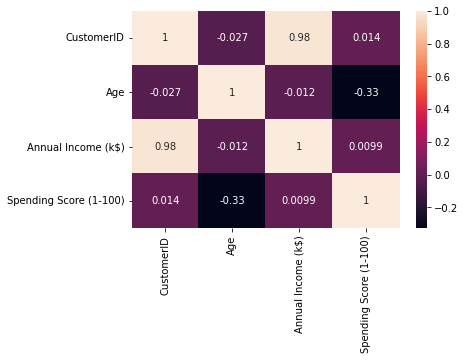

In [ ]:
sns.heatmap(dataset.corr(), annot = True)

plt.show()

### **3.Model Description**

In [ ]:
def dbscan(D, eps, MinPts):
    '''
    Cluster the dataset `D` using the DBSCAN algorithm.
    
    dbscan takes a dataset `D` (a list of vectors), a threshold distance
    `eps`, and a required number of points `MinPts`.
    
    It will return a list of cluster labels. The label -1 means noise, and then
    the clusters are numbered starting from 1.
    '''
 
    # This list will hold the final cluster assignment for each point in D.
    # There are two reserved values:
    #    -1 - Indicates a noise point
    #     0 - Means the point hasn't been considered yet.
    # Initially all labels are 0.    
    labels = [0]*len(D)

    # C is the ID of the current cluster.    
    C = 0
    
    # This outer loop is just responsible for picking new seed points--a point
    # from which to grow a new cluster.
    # Once a valid seed point is found, a new cluster is created, and the 
    # cluster growth is all handled by the 'expandCluster' routine.
    
    # For each point P in the Dataset D...
    # ('P' is the index of the datapoint, rather than the datapoint itself.)
    for P in range(0, len(D)):
    
        # Only points that have not already been claimed can be picked as new 
        # seed points.    
        # If the point's label is not 0, continue to the next point.
        if not (labels[P] == 0):
           continue
        
        # Find all of P's neighboring points.
        NeighborPts = region_query(D, P, eps)
        
        # If the number is below MinPts, this point is noise. 
        # This is the only condition under which a point is labeled 
        # NOISE--when it's not a valid seed point. A NOISE point may later 
        # be picked up by another cluster as a boundary point (this is the only
        # condition under which a cluster label can change--from NOISE to 
        # something else).
        if len(NeighborPts) < MinPts:
            labels[P] = -1
        # Otherwise, if there are at least MinPts nearby, use this point as the 
        # seed for a new cluster.    
        else: 
           C += 1
           grow_cluster(D, labels, P, NeighborPts, C, eps, MinPts)
    
    # All data has been clustered!
    return labels

In [ ]:

def grow_cluster(D, labels, P, NeighborPts, C, eps, MinPts):
    '''
    Grow a new cluster with label `C` from the seed point `P`.
    
    This function searches through the dataset to find all points that belong
    to this new cluster. When this function returns, cluster `C` is complete.
    
    Parameters:
      `D`      - The dataset (a list of vectors)
      `labels` - List storing the cluster labels for all dataset points
      `P`      - Index of the seed point for this new cluster
      `NeighborPts` - All of the neighbors of `P`
      `C`      - The label for this new cluster.  
      `eps`    - Threshold distance
      `MinPts` - Minimum required number of neighbors
    '''

    # Assign the cluster label to the seed point.
    labels[P] = C
    
    # Look at each neighbor of P (neighbors are referred to as Pn). 
    # NeighborPts will be used as a FIFO queue of points to search--that is, it
    # will grow as we discover new branch points for the cluster. The FIFO
    # behavior is accomplished by using a while-loop rather than a for-loop.
    # In NeighborPts, the points are represented by their index in the original
    # dataset.
    i = 0
    while i < len(NeighborPts):    
        
        # Get the next point from the queue.        
        Pn = NeighborPts[i]
       
        # If Pn was labelled NOISE during the seed search, then we
        # know it's not a branch point (it doesn't have enough neighbors), so
        # make it a leaf point of cluster C and move on.
        if labels[Pn] == -1:
           labels[Pn] = C
        
        # Otherwise, if Pn isn't already claimed, claim it as part of C.
        elif labels[Pn] == 0:
            # Add Pn to cluster C (Assign cluster label C).
            labels[Pn] = C
            
            # Find all the neighbors of Pn
            PnNeighborPts = region_query(D, Pn, eps)
            
            # If Pn has at least MinPts neighbors, it's a branch point!
            # Add all of its neighbors to the FIFO queue to be searched. 
            if len(PnNeighborPts) >= MinPts:
                NeighborPts = NeighborPts + PnNeighborPts
            # If Pn *doesn't* have enough neighbors, then it's a leaf point.
            # Don't queue up it's neighbors as expansion points.
            #else:
                # Do nothing                
                #NeighborPts = NeighborPts               
        
        # Advance to the next point in the FIFO queue.
        i += 1        
    
    # We've finished growing cluster C!

In [ ]:
def region_query(D, P, eps):
    '''
    Find all points in dataset `D` within distance `eps` of point `P`.
    
    This function calculates the distance between a point P and every other 
    point in the dataset, and then returns only those points which are within a
    threshold distance `eps`.
    '''
    neighbors = []
    
    # For each point in the dataset...
    for Pn in range(0, len(D)):
        
        # If the distance is below the threshold, add it to the neighbors list.
        if numpy.linalg.norm(D[P] - D[Pn]) < eps:
           neighbors.append(Pn)
            
    return neighbors

In [ ]:
#f1 = data['Age'].values
f2 = dataset['Annual Income (k$)'].values
f3 = dataset['Spending Score (1-100)'].values
X = numpy.array(list(zip(f2, f3)))
cluster_labels = numpy.array(dbscan(X, 3, 4))
#db = DBSCAN(eps = 3, min_samples = 4).fit(X)
#cluster_labels = db.labels_
print(cluster_labels)


[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1 -1  1 -1  1  1 -1  1 -1 -1
  1 -1  3  2  2  3  2 -1  2  2 -1  3  2  3 -1 -1 -1  5 -1  4  5  4  4  5
  5  5  4  5  4  5 -1  5  5  4  5  5  4  5  5  5  4  5  5  5  4  6  4  6
  6 -1  6 -1 -1  7 -1 -1 -1  7  8  7 -1  7  8 -1  8  7 -1  7  8 -1 -1  9
 -1 -1 -1 -1 -1  9 -1  9 -1 -1 -1  9 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1]


In [ ]:
n_clusters_ = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise_ = list(cluster_labels).count(-1)

print("Estimated number of clusters: " , n_clusters_)
print("Estimated number of noise points: " , n_noise_)


Estimated number of clusters:  9
Estimated number of noise points:  135


# **4.Performance Analysis**

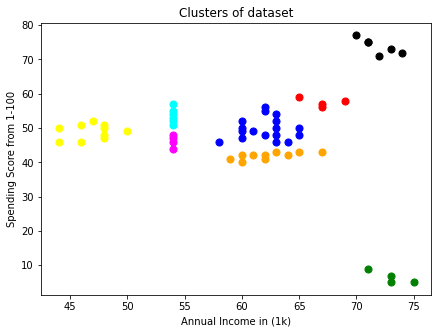

Quality of Clustering:  -0.22656703338648562


In [ ]:
plt.figure(figsize=(7,5))
plt.scatter(X[cluster_labels == 0, 0], X[cluster_labels == 0, 1], s = 50, c = 'pink')
plt.scatter(X[cluster_labels == 1, 0], X[cluster_labels == 1, 1], s = 50, c = 'yellow')
plt.scatter(X[cluster_labels == 2, 0], X[cluster_labels == 2, 1], s = 50, c = 'cyan')
plt.scatter(X[cluster_labels == 3, 0], X[cluster_labels == 3, 1], s = 50, c = 'magenta')
plt.scatter(X[cluster_labels == 4, 0], X[cluster_labels == 4, 1], s = 50, c = 'orange')
plt.scatter(X[cluster_labels == 5, 0], X[cluster_labels == 5, 1], s = 50, c = 'blue')
plt.scatter(X[cluster_labels == 6, 0], X[cluster_labels == 6, 1], s = 50, c = 'red')
plt.scatter(X[cluster_labels == 7, 0], X[cluster_labels == 7, 1], s = 50, c = 'black')
plt.scatter(X[cluster_labels == 8, 0], X[cluster_labels == 8, 1], s = 50, c = 'green')
plt.xlabel('Annual Income in (1k)')
plt.ylabel('Spending Score from 1-100')
plt.title('Clusters of dataset')
plt.show()
if(n_clusters_ > 1):
  sil = silhouette_score(X, cluster_labels,
                         metric='euclidean',
                         sample_size = len(dataset))
  print("Quality of Clustering: ", sil)